### Import Packages

In [21]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn')

pd.set_option('display.max_rows', 250)
%matplotlib inline
#print(plt.style.available)

### Import & Display Dataset

In [36]:
df = pd.read_csv('C:/Users/abenedetto/Documents/kpis_with_flags_data.csv',
                parse_dates = ['observation_date'])

print('Dataset Shape:', df.shape)
print('Max Obs. Date:',df['observation_date'].min())
print('Max Obs. Date:',df['observation_date'].max())
df.head()

Dataset Shape: (1826, 7)
Max Obs. Date: 2017-01-01 00:00:00
Max Obs. Date: 2021-12-31 00:00:00


,observation_date,sales_num,sales_value_gbp,fl_last_working_day,fl_first_working_day,fl_last_friday,fl_new_year
0,2017-01-01,779.0,453330.60,0,0,0,1
1,2017-01-02,1158.0,869178.32,0,1,0,0
2,2017-01-03,1406.0,1169019.45,0,0,0,0
3,2017-01-04,1484.0,1216797.41,0,0,0,0
4,2017-01-05,1516.0,1265103.60,0,0,0,0


### VIZ 1 - Plot KPIs to forecast

Text(0.5, 1.0, 'Sales Value (£M) By Day')

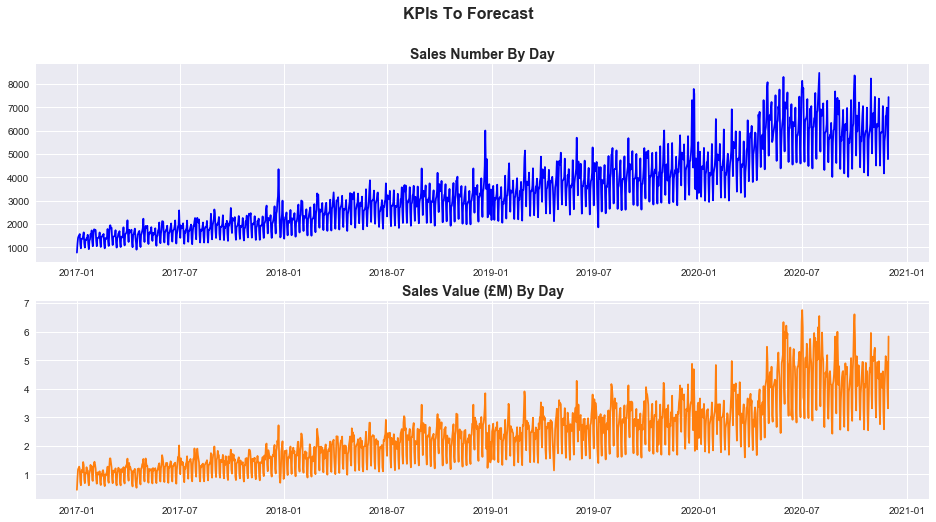

In [7]:
fig, (ax1, ax2) = plt.subplots(2, figsize = (16, 8))
fig.suptitle('KPIs To Forecast', fontsize=16, fontweight="bold")

ax1.plot(df['observation_date'], df['sales_num'], color = 'blue')
ax2.plot(df['observation_date'], (df['sales_value_gbp']/1000000), 'tab:orange')

ax1.set_title('Sales Number By Day', fontsize=14,fontweight='heavy')
ax2.set_title('Sales Value (£M) By Day', fontsize=14, fontweight='heavy' )

### Set Relevant Dates & Run Basic Model

In [58]:
cutoff_date = pd.to_datetime('2020-10-31') 
test_end_date = pd.to_datetime('2020-11-30')

forecast_start_date = pd.to_datetime('2020-11-01')
forecast_end_date = pd.to_datetime('2022-01-01')
days_to_forecast = pd.Timedelta(forecast_end_date - forecast_start_date).days



kpis = ['sales_num']
#kpis = ['sales_num', 'sales_value_gbp']

for kpi in kpis:
    print('Forecasting KPI: ', kpi)
    df_train = df.loc[(df[kpi].notnull()) & (df['observation_date'] <= cutoff_date ), ['observation_date', kpi]]

    df_train = df_train.rename(columns={'observation_date': 'ds', kpi: 'y'})
    
    model = Prophet(interval_width=0.95,
                    growth = 'linear', 
                    seasonality_mode = 'multiplicative',
                    #changepoint_prior_scale=0.5,
                    #changepoint_range=0.95,
                    daily_seasonality = False,
                    weekly_seasonality=True,
                    yearly_seasonality=True
                    )
    model.fit(df_train)
    future_data = model.make_future_dataframe(periods= days_to_forecast )
    forecast = model.predict(future_data)[['ds','yhat_lower', 'yhat','yhat_upper', 'trend']]
    #df.loc[(df['observation_date'] > cutoff_date ), kpi ] = forecast['yhat'].astype(int)

df.tail()

Forecasting KPI:  sales_num


,observation_date,sales_num,sales_value_gbp,fl_last_working_day,fl_first_working_day,fl_last_friday,fl_new_year
1821,2021-12-27,NaN,NaN,0,0,0,0
1822,2021-12-28,NaN,NaN,0,0,0,0
1823,2021-12-29,NaN,NaN,0,0,0,0
1824,2021-12-30,NaN,NaN,0,0,0,0
1825,2021-12-31,NaN,NaN,1,0,1,0


In [12]:
forecast.head()

,ds,yhat_lower,yhat,yhat_upper,trend
0,2017-01-01,213.019144,901.936392,1570.840148,1347.302324
1,2017-01-02,554.983758,1257.597625,2003.110286,1349.096575
2,2017-01-03,587.842719,1263.097432,1942.612558,1350.890825
3,2017-01-04,583.726490,1291.727787,2004.618928,1352.685076
4,2017-01-05,632.052741,1317.745688,2003.160868,1354.479327


### VIZ 2 - Identify Trend Changepoints over time

Text(105.25, 0.5, 'Sales Number - Daily')

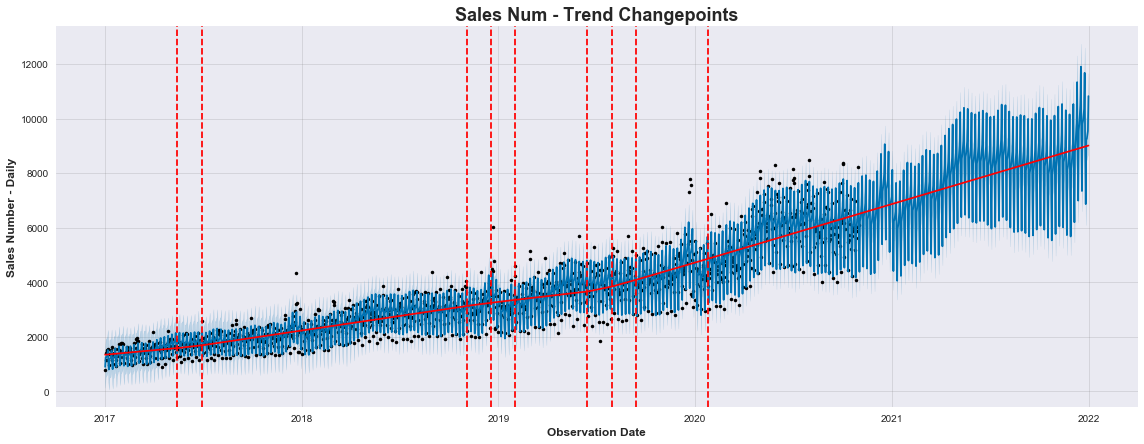

In [29]:
fig = fbplot(model, forecast, figsize=(16, 6));
ax = fig.gca()
add_changepoints_to_plot(ax, model, forecast)


ax.set_title("Sales Num - Trend Changepoints", size=18, fontweight='heavy')
ax.set_xlabel('Observation Date', size = '12' , fontweight='heavy')
ax.set_ylabel('Sales Number - Daily', fontweight='heavy', size = '12')


### VIZ 3 - Plot Model Forecast Vs Data set

,observation_date,sales_num,yhat_lower,yhat,yhat_upper,trend
1821,2021-12-27,NaN,4769.688615,8682.390536,12418.178952,8697.019329
1822,2021-12-28,NaN,4619.312470,8698.956848,12506.116827,8702.455652
1823,2021-12-29,NaN,4827.307710,8855.079899,12799.722743,8707.891975
1824,2021-12-30,NaN,4904.017576,8980.752574,12813.935089,8713.328297
1825,2021-12-31,NaN,5635.078651,10221.931290,14703.757885,8718.764620


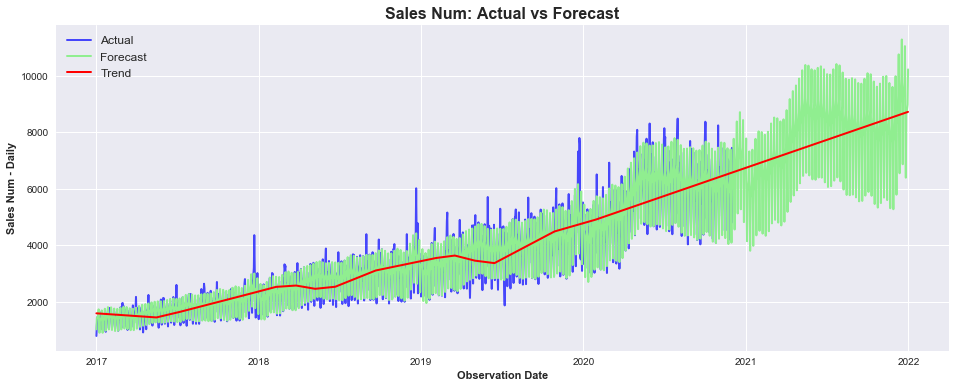

In [55]:
# Join Original Dataset With Forecast
combined_df = df.join(forecast, how = 'outer')

plt.figure(figsize=(16,6))
plt.plot(combined_df['observation_date'], combined_df['sales_num'], 
         linewidth=2, color = 'blue' ,alpha = 0.7, label = 'Actual')
plt.plot(combined_df['observation_date'], combined_df['yhat'], 
         linewidth=2, color = 'lightgreen', label = 'Forecast')
plt.plot(combined_df['observation_date'], combined_df['trend'], 
         linewidth=2, color = 'red', label = 'Trend')

plt.title('Sales Num: Actual vs Forecast', fontsize=16, fontweight='heavy' )
plt.xlabel('Observation Date', fontweight='heavy')
plt.ylabel('Sales Num - Daily', fontweight='heavy')
plt.legend(loc="upper left", fontsize = 'large')

#plt.xlim(pd.to_datetime('2019-10-01'), pd.to_datetime('2019-12-31'))
combined_df[['observation_date', 'sales_num', 'yhat_lower' , 'yhat', 'yhat_upper' ,'trend']].tail()

### VIZ 4 - Plot Model Forecast For Relevant Period Vs Orig Data Set

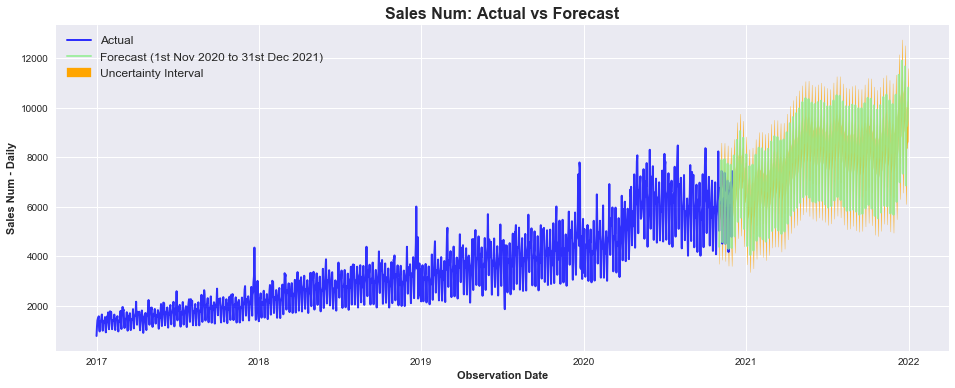

In [59]:
forecast_adj = forecast.loc[forecast['ds'] >=forecast_start_date, ['yhat_lower','yhat','yhat_upper']]
combined_df_adj = df.join(forecast_adj, how = 'outer')

plt.figure(figsize=(16,6))
plt.plot(combined_df_adj['observation_date'], combined_df_adj['sales_num'], 
         linewidth=2, color = 'blue' ,alpha = 0.8, label = 'Actual')
plt.plot(combined_df_adj['observation_date'], combined_df_adj['yhat'], 
         linewidth=2, color = 'lightgreen', alpha = 0.8 , label = 'Forecast (1st Nov 2020 to 31st Dec 2021)')
plt.fill_between(combined_df_adj['observation_date'], combined_df_adj['yhat_upper'], combined_df_adj['yhat_lower'], 
                 color='orange', label = 'Uncertainty Interval')

plt.title('Sales Num: Actual vs Forecast', fontsize=16, fontweight='heavy' )
plt.xlabel('Observation Date', fontweight='heavy')
plt.ylabel('Sales Num - Daily', fontweight='heavy')
plt.legend(loc="upper left", fontsize = 'large')

#plt.xlim(pd.to_datetime('2020-11-01'), pd.to_datetime('2020-12-31'))

### Model Evaluation With MAPE

In [62]:
combined_df_test = combined_df.loc[(combined_df['observation_date'] > cutoff_date)
                                    & (combined_df['observation_date'] <= test_end_date )]


mape =(np.mean(np.abs(combined_df_test['sales_num']-combined_df_test['yhat'])/
               np.abs(combined_df_test['sales_num'])))*100
#print('MAPE:',  mape)